### 필요한 모듈 불러오기

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

### FinanceDataReader 이용하여 주식 데이터 불러오기

In [53]:
df = 'AXP' # 아메리칸 익스프레스 주가
# df = 'AAPL' # 애플 주가
df = fdr.DataReader(df)
df.info()
df.head()


c:\Program Files\Python38\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)
c:\Program Files\Python38\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10635 entries, 1980-03-18 to 2022-05-20
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10635 non-null  float64
 1   Open    10635 non-null  float64
 2   High    10635 non-null  float64
 3   Low     10635 non-null  float64
 4   Volume  10635 non-null  float64
 5   Change  10635 non-null  float64
dtypes: float64(6)
memory usage: 581.6 KB


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.92,1.92,1.92,1.85,3080000.0,0.0267
1980-03-19,1.92,1.92,1.94,1.90,744010.0,0.0000
1980-03-20,1.88,1.88,1.91,1.87,856800.0,-0.0208
1980-03-21,1.89,1.89,1.90,1.86,986400.0,0.0053
1980-03-24,1.87,1.87,1.89,1.86,1560000.0,-0.0106


Text(0, 0.5, 'price')

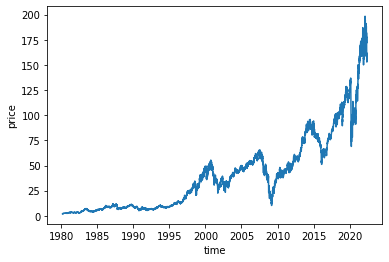

In [54]:
# 표
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

### 데이터 전처리

#### 중위값

In [55]:
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices + low_prices) / 2
df['Mid'] = mid_prices
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10635 entries, 1980-03-18 to 2022-05-20
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10635 non-null  float64
 1   Open    10635 non-null  float64
 2   High    10635 non-null  float64
 3   Low     10635 non-null  float64
 4   Volume  10635 non-null  float64
 5   Change  10635 non-null  float64
 6   Mid     10635 non-null  float64
dtypes: float64(7)
memory usage: 664.7 KB


#### 이동평균선

In [56]:
#이동평균선 5일, 20일, 200일 
ma5 = df['Close'].rolling(window=5).mean()
df['MA5'] = ma5
ma20 = df['Close'].rolling(window=20).mean()
df['MA20'] = ma20
ma200 = df['Close'].rolling(window=200).mean()
df['MA200'] = ma200


df = df.dropna()

#### GC DC

In [57]:
gc_point = []
dc_point =[]

for i in range(len(df['MA20'])):
    gc_point.append(0)
    dc_point.append(0)

for i in range(len(df['MA200'])-1):
    if df['MA20'][i] <= df['MA200'][i] and df['MA20'][i+1] > df['MA200'][i+1]:
        gc_point[i]= 1
    elif df['MA20'][i] >= df['MA200'][i] and df['MA20'][i+1] < df['MA200'][i+1]:
        dc_point[i]= 1
    
df.insert(len(df.columns), "GC", gc_point)
df.insert(len(df.columns), "DC", dc_point)

#### Bollinger Bands

mbb = 중심선 = 주가의 20 기간 이동평균선 = ma20   
ubb = 상한선 = 중심선 + 주가의 20기간 표준편차 * 2   
lbb = 하한선 = 중심선 – 주가의 20기간 표준편차 * 2   
perb = %b = (주가 – 하한선) / (상한선 – 하한선) = (close - lbb) / (ubb - lbb)   
bw = 밴드폭 (Bandwidth) = (상한선 – 하한선) / 중심선 = (ubb - lbb) / mbb   

In [60]:
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 표준편차
df['upper'] = df['MA20'] + (df['stddev'] * 2) # 상단 볼린저 밴드
df['lower'] = df['MA20'] - (df['stddev'] * 2) # 하단 볼린저 밴드

             Close    Open    High     Low     Volume  Change      Mid  \
Date                                                                     
2022-05-09  161.02  165.03  166.02  160.38  4490000.0 -0.0367  163.200   
2022-05-10  161.83  163.42  164.73  158.39  3010000.0  0.0050  161.560   
2022-05-11  159.39  161.73  164.94  159.04  2630000.0 -0.0151  161.990   
2022-05-12  153.27  155.60  157.15  149.88  5010000.0 -0.0384  153.515   
2022-05-13  158.75  155.96  160.09  155.88  3330000.0  0.0358  157.985   
2022-05-16  156.43  157.41  158.74  154.32  2750000.0 -0.0146  156.530   
2022-05-17  161.85  161.07  162.76  158.40  2920000.0  0.0346  160.580   
2022-05-18  156.10  160.79  160.85  155.40  2690000.0 -0.0355  158.125   
2022-05-19  154.00  153.57  156.46  153.25  2770000.0 -0.0135  154.855   
2022-05-20  153.24  154.35  154.80  149.71  2980000.0 -0.0049  152.255   

                MA5      MA20        MA60      MA200  GC  DC     stddev  \
Date                                

#### 스케일링

In [ ]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(df[scale_cols])